## Set-up


In [1]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from helper import *


In [2]:
def random_color():
    # Generate random values for red, green, and blue
    r, g, b = [random.randint(0, 255) for i in range(3)]
    # Create a numpy array with the random RGB values and fixed alpha value of 255
    color = np.array([r, g, b, 255], dtype=np.uint8)
    return color

# print(color)  # prints something like [112  43 194 255]


In [3]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


## Example image


In [4]:
image_path = 'images/fur_min.jpeg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


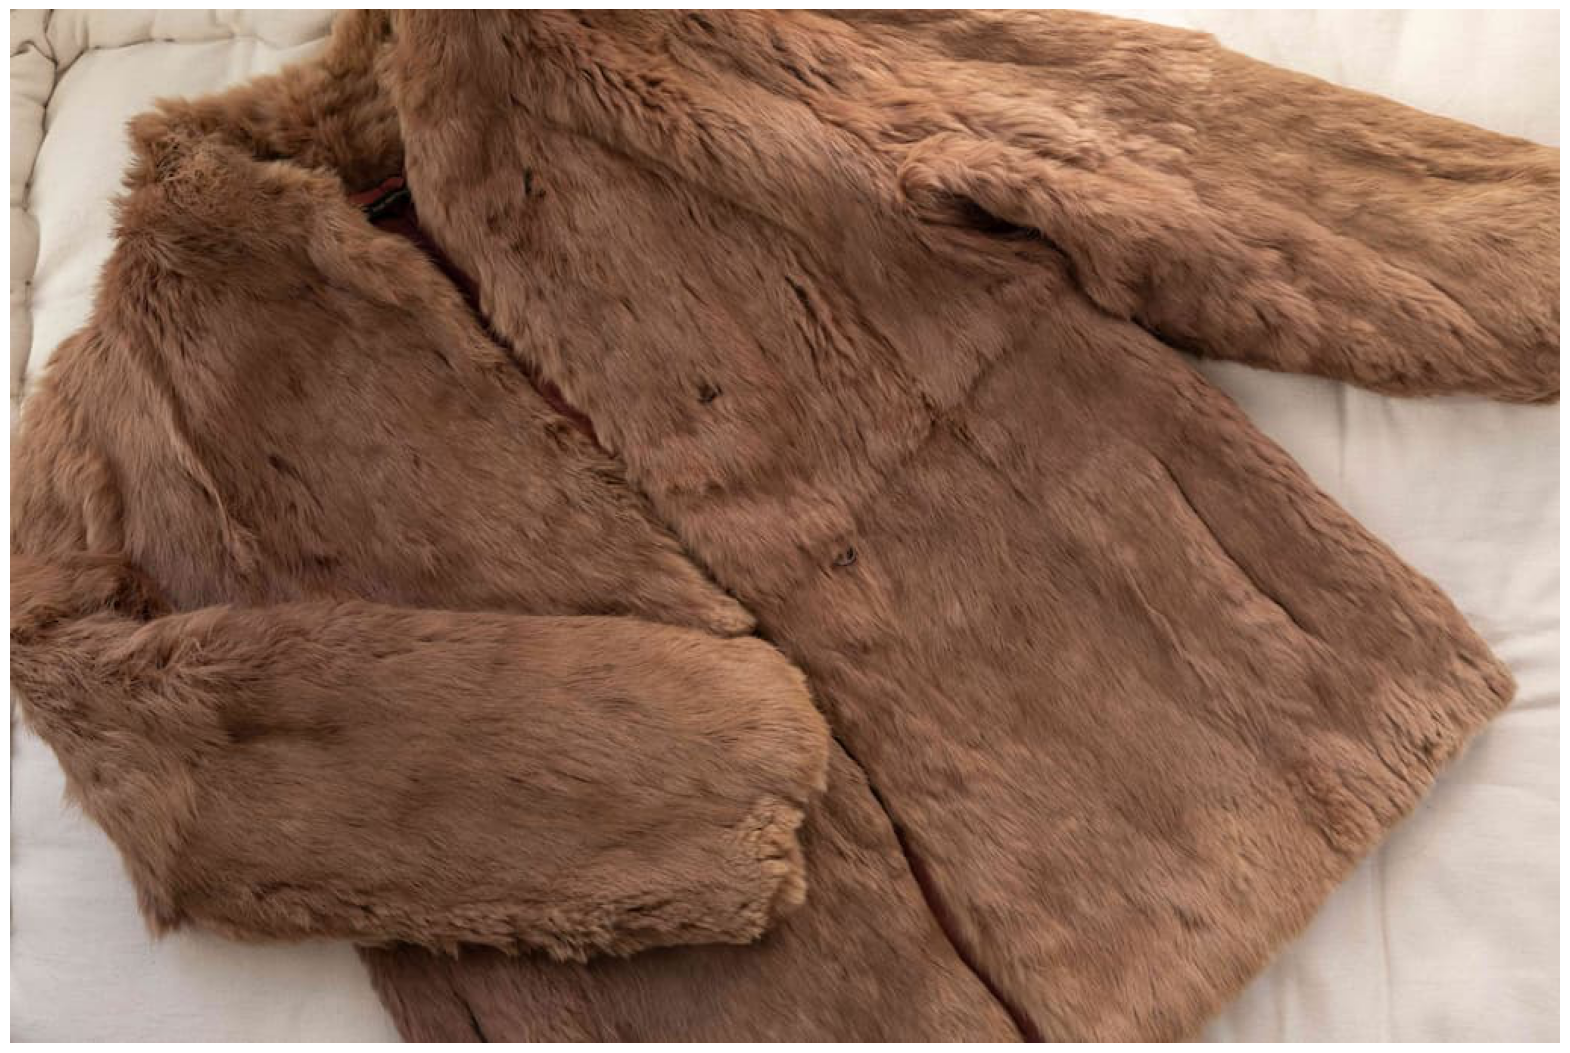

In [5]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()


## Automatic mask generation


To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.


In [6]:
import sys
# sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/Users/susanto/Documents/Proyek/best-remove-background/models/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

# print(mask_generator)


To generate masks, just run `generate` on an image.


In [7]:
masks = mask_generator.generate(image)


Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

- `segmentation` : the mask
- `area` : the area of the mask in pixels
- `bbox` : the boundary box of the mask in XYWH format
- `predicted_iou` : the model's own prediction for the quality of the mask
- `point_coords` : the sampled input point that generated this mask
- `stability_score` : an additional measure of mask quality
- `crop_box` : the crop of the image used to generate this mask in XYWH format


In [8]:
# print(masks[0])


In [9]:
# plt.imshow(masks[2]["segmentation"])


In [10]:
print(len(masks))
print(masks[0].keys())


22
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [11]:
# RGB numpy array to RGBA numpy array
rgba_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
rgba_image[:, :, :3] = image
rgba_image[:, :, 3] = 255


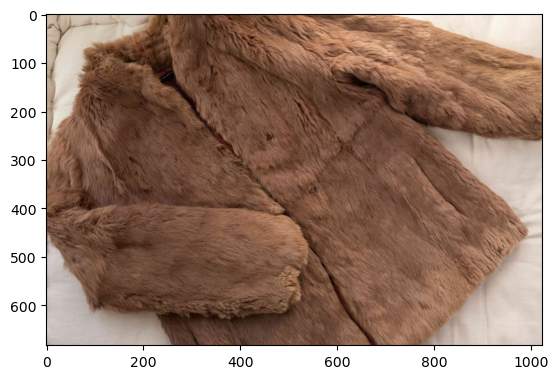

In [12]:
plt.imshow(rgba_image)


In [13]:
from helper import *
from PIL import Image


In [14]:
# # Make blank image with same size
# base_img = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)


In [15]:


sys.path.append(
    '/Users/susanto/Documents/Proyek/best-remove-background/latihan-remove-background/PytorchSuccessExample/algorithm/clustering')


sys.path.append(
    '/Users/susanto/Documents/Proyek/best-remove-background/latihan-remove-background/PytorchSuccessExample/algorithm/filter')



from filter import dominantTransparent, detect_dominant_color, dominant_transparent_rgba, detect_dominant_color_rgba,color_diff_rgba
from clustering import getMasksColorCluster

In [16]:
from scipy.ndimage import binary_dilation, binary_erosion


In [17]:
def get_edge_mask(mask):
    # Dilate the mask to get the boundary pixels
    dilated_mask = binary_dilation(mask)
    # Erode the mask to get the interior pixels
    eroded_mask = binary_erosion(mask)
    # Subtract the eroded mask from the dilated mask to get the boundary pixels
    edge_mask = np.logical_and(dilated_mask, np.logical_not(eroded_mask))
    return edge_mask


In [18]:
print(type(image))

print(rgba_image.shape)


<class 'numpy.ndarray'>
(683, 1024, 4)


In [19]:
# Make blank image with same size
base_img = np.zeros(
    (rgba_image.shape[0], rgba_image.shape[1], 4), dtype=np.uint8)

for i in range(0, len(masks)):
    # Apply Segment Mask
    segmentation = masks[i]['segmentation']
    copied_img = rgba_image.copy()
    copied_img[segmentation == False] = [0, 0, 0, 0]

    # patch all segmentation part into blank rgba_image
    maskAll = (base_img[:, :, 3] <= copied_img[:, :, 3])
    base_img[maskAll] = copied_img[maskAll]

# Rest are that SAM not detected
rest = base_img[:, :, 3] != 0
copied_img = rgba_image.copy()
copied_img[rest] = [0, 0, 0, 0]


PIL_image, bounding = cropUnusedBlankPixel(copied_img)
PIL_image.save("output/rest.png")


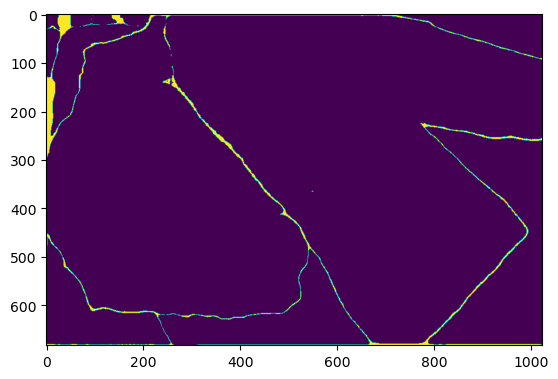

In [20]:
alpha_channel = copied_img[:, :, 3]  # Extract the alpha channel
rest_binary_mask = alpha_channel > 0
plt.imshow(rest_binary_mask)


In [21]:
num_true = np.count_nonzero(rest_binary_mask)

item = {
    "segmentation": rest_binary_mask,
    "area": num_true,
    "bbox": [0, 0, rgba_image.shape[0], rgba_image.shape[1]],
}

print(num_true)
# print(masks)

masks.append(item)


16075


In [22]:
binary_mask = np.zeros((image.shape[0], image.shape[1]), dtype=bool)

class_img = np.zeros((image.shape[0], image.shape[1]))


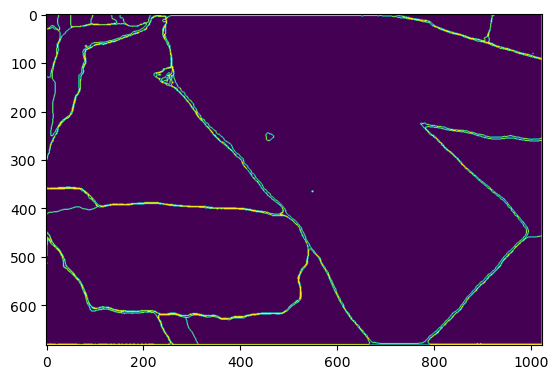

In [23]:
for i in range(0, len(masks)):
    # Apply Segment Mask
    segmentation = masks[i]['segmentation']

    # Create class map
    class_img[segmentation == True] = i

    # Where is the edges of area
    edge = get_edge_mask(segmentation)
    plt.imshow(edge)

    binary_mask = np.logical_or(binary_mask, edge)

plt.imshow(binary_mask)


Show all the masks overlayed on the image.


In [24]:
def find_dominant(arr):
    # Get unique colors and their counts
    unique, counts = np.unique(arr, axis=0, return_counts=True)

    # Sort the counts in descending order
    sorted_counts_indices = np.argsort(-counts)

    # Get the color with the highest count as the dominant color
    dominant_color = unique[sorted_counts_indices[0]]

    return dominant_color


In [25]:
def find_closest_color(arr, compare_rgba):
    arr = np.array(arr)
    arr = arr.astype(int)
    # Find the index of the closest color
    distances = np.linalg.norm(arr - compare_rgba, axis=1)
    closest_index = np.argmin(distances)
    return closest_index


In [26]:
def calculate_darkness(rgba):
    return 1.0 - ((0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]) / 255.0)


In [27]:
def find_closest_color_darkness(rgba_array,target_rgba):
    darkness_array = np.array([calculate_darkness(rgba) for rgba in rgba_array])

    # Calculate the darkness of the target RGBA value
    target_darkness = calculate_darkness(target_rgba)

    # Find the index of the closest RGBA value based on darkness
    closest_index = np.argmin(np.abs(darkness_array - target_darkness))
    
    return closest_index


In [28]:
import math


In [29]:
def edges_repair(rgba_image, class_img, binary_mask, sample=10):
    height = rgba_image.shape[0]
    width = rgba_image.shape[1]

    # class_img
    # rgba_image
    arr = []
    x_floor = math.floor(sample/2)
    left = x_floor
    right = sample-x_floor
    index = 0

    change_color = []

    class_img_out = class_img.copy()

    for y in range(left, height-right):
        for x in range(left, width-right):
            # print(f"Pixel ({x}, {y}): {image[y][x]}")
            if (binary_mask[y][x] == True):
                start_row = y-left
                start_col = x-left
                
                class_arr = class_img[start_row:start_row +
                                      sample, start_col:start_col+sample]

                unique_class_arr = np.unique(class_arr)
                if (len(unique_class_arr) > 0):
                    # print(unique_class_arr)
                    cropped_image_filter = rgba_image[start_row:start_row +
                                                      sample, start_col:start_col+sample]

                    # find dominant color in that class
                    arr_dominant = []
                    for u in unique_class_arr:
                        arr_color = cropped_image_filter[class_arr == u]
                        dom = find_dominant(arr_color)
                        arr_dominant.append(dom)

                    # print(class_arr.shape)
                    # print(cropped_image_filter.shape)
                    class_arr_out = class_arr.copy()

                    # Iterate over filter
                    for y_filter in range(1, cropped_image_filter.shape[0]-1):
                        for x_filter in range(1, cropped_image_filter.shape[1]-1):
                            
                            current_class = class_arr[y_filter][x_filter]

                            can = False
                            counter=0
                            # Only change is its in the edge
                            if (y_filter > 0 and x_filter > 0):
                                top_class = class_arr[y_filter-1][x_filter]
                                left_class = class_arr[y_filter][x_filter-1]
                                right_class = class_arr[y_filter][x_filter+1]
                                bottom_class = class_arr[y_filter+1][x_filter]

                                if(current_class == top_class):
                                    counter+=1

                                if(current_class == left_class):
                                    counter+=1

                                if(current_class == right_class):
                                    counter+=1
                                
                                if(current_class == bottom_class):
                                    counter+=1

                                if (counter<3):
                                    can = True

                            if(can):
                                compare_rgba = cropped_image_filter[y_filter][x_filter]
                                idx = find_closest_color(
                                    arr_dominant, compare_rgba)

                            
                                must_class = unique_class_arr[idx]
                                # print("current_class ",current_class)

                                if (current_class != must_class):
                                    # change class
                                    # if(current_class==4.0):
                                    # print("compare_rgba ", compare_rgba)
                                    # print("arr_dominant")
                                    # print(arr_dominant)
                                    # print("change color ", compare_rgba,
                                    #       arr_dominant[idx])
                                    # print("change class ", current_class, must_class)
                                    class_arr_out[y_filter][x_filter] = must_class

                                    change_color.append(
                                        [start_row+y_filter, start_col+x_filter, current_class, must_class])
                                    class_img_out[start_row +
                                                y_filter][start_col+x_filter] = must_class

                                    # print(
                                    #     "current class ", class_img_out[start_row+y_filter][start_col+x_filter])

                    # PIL_image = Image.fromarray(cropped_image_filter)
                    # PIL_image.save("output/parts/"+str(index)+"_new.png")
                    index += 1
                    arr.append(
                        [cropped_image_filter, class_arr, class_arr_out])

    return [arr, class_img_out]


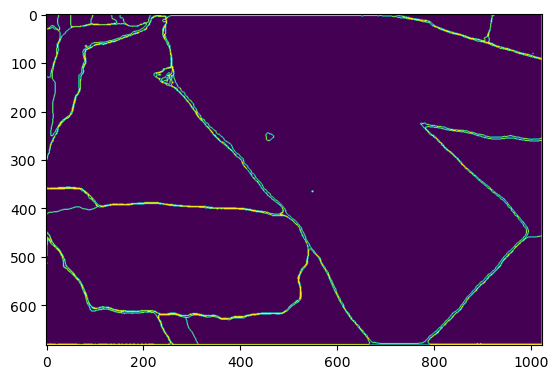

In [30]:
plt.imshow(binary_mask)

In [31]:
rgba_image.shape

(683, 1024, 4)

In [32]:
class_img.shape

(683, 1024)

In [33]:
arr, class_img_out = edges_repair(rgba_image, class_img,binary_mask, 10)


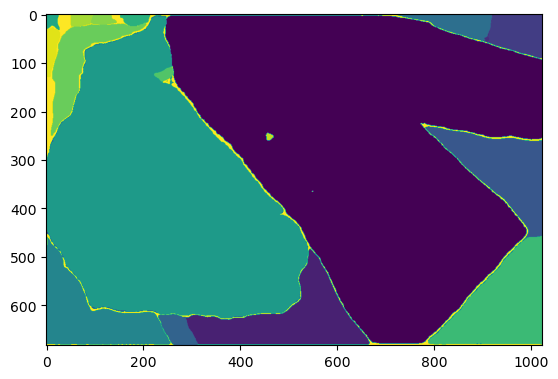

In [34]:
plt.imshow(class_img)

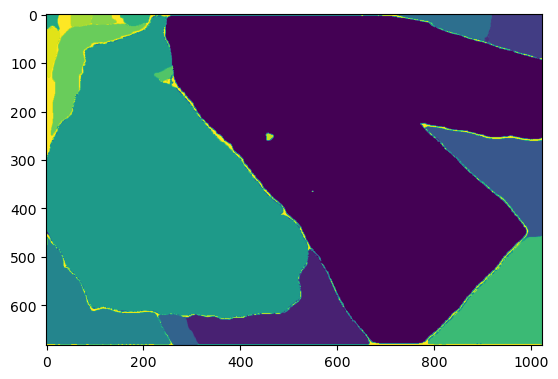

In [35]:
plt.imshow(class_img_out)

[[13. 13. 13. ...  4.  4.  4.]
 [13. 13. 13. ...  4.  4.  4.]
 [13. 13. 13. ...  4.  4.  4.]
 ...
 [ 9.  9. 10. ... 15. 15. 15.]
 [22. 22. 22. ... 15. 15. 15.]
 [22. 22. 22. ... 22. 22. 22.]]


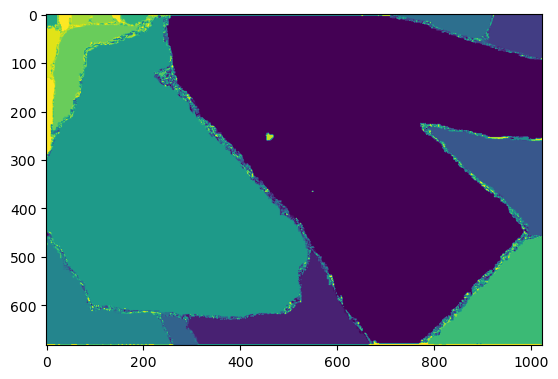

In [72]:
for i in range(50):
    arr, class_img_out = edges_repair(rgba_image, class_img_out,binary_mask, 10)

plt.imshow(class_img_out)
print(class_img_out)


In [73]:
import numpy as np

# Define a function to calculate the Euclidean distance between two RGBA colors
def calculate_distance(rgba1, rgba2):
    return np.sqrt(np.sum((rgba1 - rgba2) ** 2))

# Define two RGBA colors to compare
rgba1 = np.array([255, 0, 10, 255], dtype=np.uint8)  # red
rgba2 = np.array([0, 255, 255, 255], dtype=np.uint8)  # green

# Calculate the Euclidean distance between the two colors
distance = calculate_distance(rgba1, rgba2)

print(distance)  # prints the Euclidean distance between the two colors


11.090536506409418


In [74]:
arr_color = []
for i in range(len(masks)):
    arr_color.append(random_color())


print(arr_color)

[array([ 47, 149,   4, 255], dtype=uint8), array([ 35,  60, 180, 255], dtype=uint8), array([197,  52, 232, 255], dtype=uint8), array([233, 164, 140, 255], dtype=uint8), array([190, 193, 246, 255], dtype=uint8), array([  4, 162, 243, 255], dtype=uint8), array([ 10,  72,  32, 255], dtype=uint8), array([205, 147, 166, 255], dtype=uint8), array([ 88, 149,  55, 255], dtype=uint8), array([117,  48,  68, 255], dtype=uint8), array([138,  67,  54, 255], dtype=uint8), array([217, 198,  65, 255], dtype=uint8), array([183, 116,   4, 255], dtype=uint8), array([100, 133,  61, 255], dtype=uint8), array([200, 177,  60, 255], dtype=uint8), array([208, 240,  72, 255], dtype=uint8), array([  8,  74,  42, 255], dtype=uint8), array([245,  82, 160, 255], dtype=uint8), array([  7, 141,  50, 255], dtype=uint8), array([119, 200, 249, 255], dtype=uint8), array([120,  15, 184, 255], dtype=uint8), array([121, 245,  16, 255], dtype=uint8), array([150,  21,  96, 255], dtype=uint8)]


In [75]:
def image_class_to_color(im):
    unique_class_arr = np.unique(im)
    new_im = np.zeros((im.shape[0], im.shape[1], 4), dtype=np.uint8)
    for u in unique_class_arr:
        new_im[im==u] = arr_color[int(u)]

    return new_im

In [76]:
# plt.imshow(arr[0][1])
# print(arr[0][1])

# k = image_class_to_color(arr[0][1])
# plt.imshow(k)

In [77]:
print(len(arr))

17016


In [78]:
# index = 0
# for report in arr:
#     PIL_image = Image.fromarray(report[0])
#     PIL_image.save("output/parts/"+str(index)+"_a.png")

#     PIL_image = Image.fromarray(image_class_to_color(report[1]))
#     PIL_image.save("output/parts/"+str(index)+"_b.png")

#     PIL_image = Image.fromarray(image_class_to_color(report[2]))
#     PIL_image.save("output/parts/"+str(index)+"_c.png")
#     index += 1


In [79]:
class_color_img = class_img

In [80]:
print(arr[0][0].shape)


(10, 10, 4)


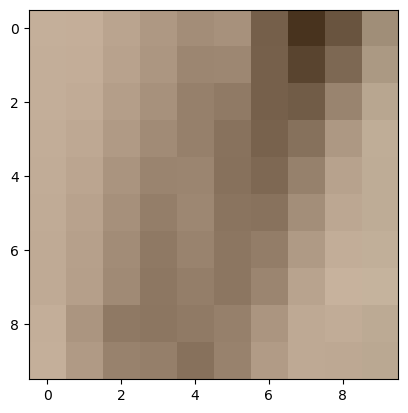

In [81]:
plt.imshow(arr[0][0])


[[13. 13. 13. 13. 13. 13. 13. 22. 22. 22.]
 [13. 13. 13. 22. 19. 19. 21. 22. 22. 22.]
 [13. 13. 13. 13. 19. 19. 21. 22. 22. 22.]
 [13. 13. 13. 19. 19. 17. 21. 22. 22. 22.]
 [13. 13. 13. 19. 19. 17. 21. 22. 22. 22.]
 [13. 13. 13. 19. 19. 19. 17. 22. 22. 22.]
 [13. 13. 13. 19. 19. 19. 19. 22. 22. 22.]
 [13. 13. 13. 19. 19. 19. 19. 22. 22. 22.]
 [13. 13. 13. 19. 19. 19. 22. 22. 22. 22.]
 [13. 13. 13. 19. 17. 19. 22. 22. 22. 22.]]


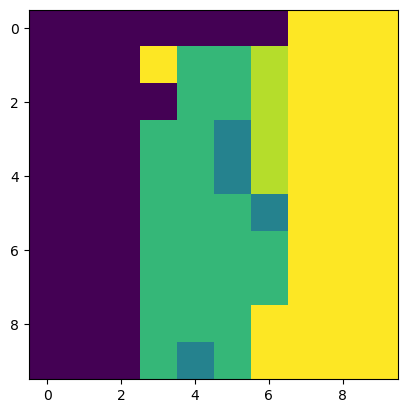

In [82]:
plt.imshow(arr[0][1])
print(arr[0][1])


[[13. 13. 13. 13. 13. 13. 13. 22. 22. 22.]
 [13. 13. 13. 22. 19. 19. 21. 22. 22. 22.]
 [13. 13. 13. 22. 19. 19. 21. 22. 22. 22.]
 [13. 13. 13. 19. 19. 17. 21. 22. 22. 22.]
 [13. 13. 13. 19. 19. 17. 21. 22. 22. 22.]
 [13. 13. 13. 19. 19. 19. 17. 22. 22. 22.]
 [13. 13. 13. 19. 19. 19. 19. 22. 22. 22.]
 [13. 13. 13. 19. 19. 19. 19. 22. 22. 22.]
 [13. 13. 13. 19. 19. 19. 22. 22. 22. 22.]
 [13. 13. 13. 19. 17. 19. 22. 22. 22. 22.]]


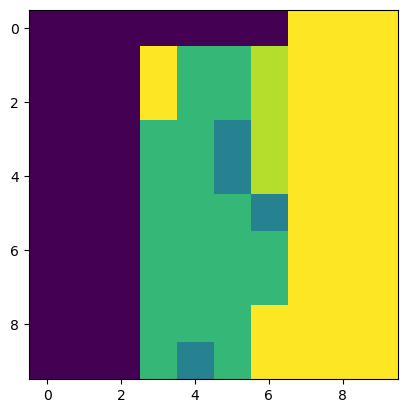

In [83]:
plt.imshow(arr[0][2])

print(arr[0][2])

In [84]:
# for i in change_color:
#     print(i[2], i[3], class_img_out[i[0]][i[1]])


In [85]:
print(class_img)


[[13. 13. 13. ...  4.  4.  4.]
 [13. 13. 13. ...  4.  4.  4.]
 [13. 13. 13. ...  4.  4.  4.]
 ...
 [ 9.  9. 10. ... 15. 15. 15.]
 [22. 22. 22. ... 15. 15. 15.]
 [22. 22. 22. ... 22. 22. 22.]]


In [86]:
class_img

array([[13., 13., 13., ...,  4.,  4.,  4.],
       [13., 13., 13., ...,  4.,  4.,  4.],
       [13., 13., 13., ...,  4.,  4.,  4.],
       ...,
       [ 9.,  9., 10., ..., 15., 15., 15.],
       [22., 22., 22., ..., 15., 15., 15.],
       [22., 22., 22., ..., 22., 22., 22.]])

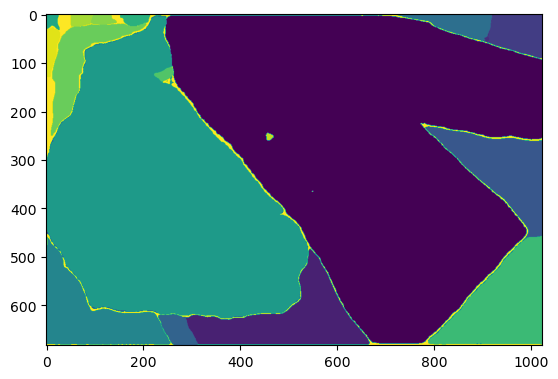

In [87]:
plt.imshow(class_img)


In [88]:
un = np.unique(class_img_out)
new_masks = []
for i in un:
    # n = class_img_out != i
    new_masks.append(class_img_out == i)
    # b = rgba_image.copy()

    # b[n] = [0, 0, 0, 0]
    # PIL_image = Image.fromarray(b)
    # PIL_image.save("output/"+str(i)+"_new.png")


# Apply mask
# for i in range(len(new_masks)):
#     m = new_masks[i]


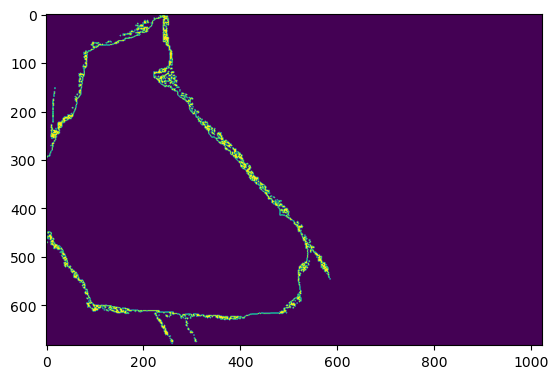

In [89]:
# for i in range(0, len(new_masks)):

a= new_masks[11]
# Where is the edges of area
edge = get_edge_mask(a)
plt.imshow(edge)

masked_rgba = rgba_image.copy()
masked_rgba[a == False] = [0, 0, 0, 0]


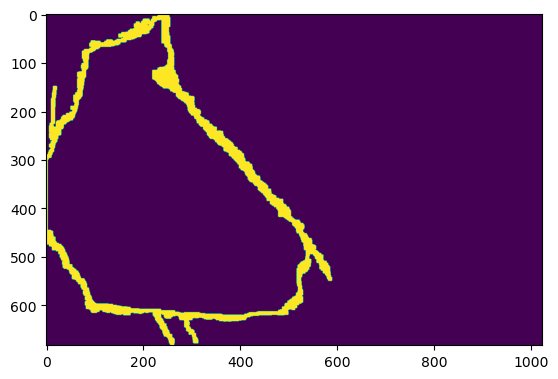

In [99]:

# Define a structuring element for dilation
structuring_element = np.ones((3, 3), dtype=bool)

# Perform dilation on the mask using the structuring element
dilated_mask = binary_dilation(edge, structure=structuring_element,iterations=3)

plt.imshow(dilated_mask)

In [90]:
def color_distance_darkness(color1, color2):
    """
    Calculates the distance between two RGBA color values based on darkness.
    Returns a value between 0 (colors are identical) and 1 (colors are maximally different).
    """
    r1, g1, b1, a1 = color1
    r2, g2, b2, a2 = color2
    
    # Calculate the "darkness" of each color as the average of its RGB values.
    darkness1 = (r1 + g1 + b1) / 3
    darkness2 = (r2 + g2 + b2) / 3
    
    # Calculate the absolute difference between the two darkness values.
    darkness_diff = abs(darkness1 - darkness2)
    
    # Normalize the distance between 0 and 1.
    return darkness_diff

In [91]:

rgba = np.zeros(
    (500, 500, 4), dtype=np.uint8)
# rgba[:, :, :, 3] = 255
# convert numpy array to PIL image
rgba = Image.fromarray(rgba)
dom = detect_dominant_color_rgba(rgba)

print(dom)


(0, 0, 0, 0)


In [104]:
def transparent_based_on_distance(rgba_image, full_image, binary_mask, sample=10):
    height = rgba_image.shape[0]
    width = rgba_image.shape[1]

    x_floor = math.floor(sample/2)
    left = x_floor
    right = sample-x_floor
    rgba_image_out = rgba_image.copy()

    for y in range(left, height-right):
        for x in range(left, width-right):
            
            if (binary_mask[y][x] == True):
                start_row = y-left
                start_col = x-left

                cropped_image_filter = rgba_image[start_row:start_row +
                                                  sample, start_col:start_col+sample]
                PIL_image = Image.fromarray(cropped_image_filter)
                dom = detect_dominant_color_rgba(PIL_image)

                before = rgba_image_out[y][x]
                
                # if (before[3] == 0):

                before_full = full_image[y][x]
                alpha = color_distance_darkness(before_full, dom)

                if (alpha < 50):
                    before_full = [0, 0, 0, 0]
                else:
                    before_full[3] = alpha

                rgba_image_out[y][x] = before_full

    return rgba_image_out


/var/folders/x2/_sq6jybs1cg0h62yg2yyvrr40000gn/T/ipykernel_8438/3893970570.py:10: RuntimeWarning: overflow encountered in ubyte_scalars
  darkness1 = (r1 + g1 + b1) / 3


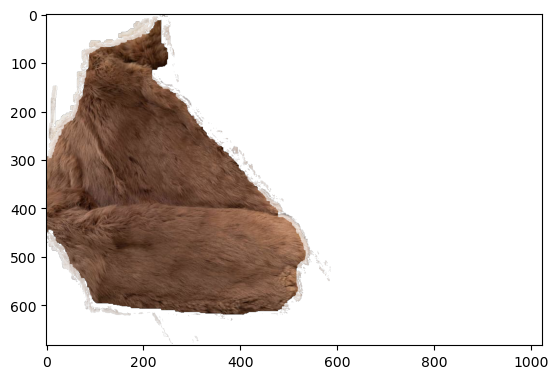

In [105]:
b=transparent_based_on_distance(masked_rgba,rgba_image,dilated_mask,10)


PIL_image = Image.fromarray(b)

PIL_image.save("output/res.png")

plt.imshow(b)

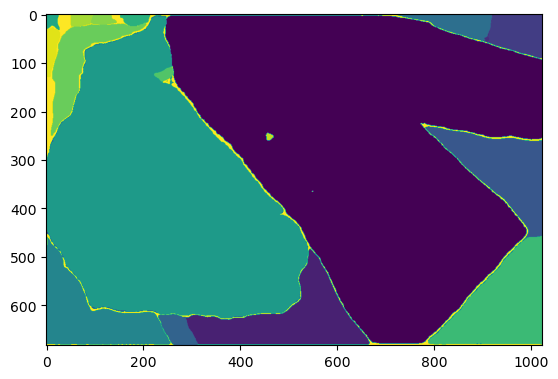

In [58]:
plt.imshow(class_img)


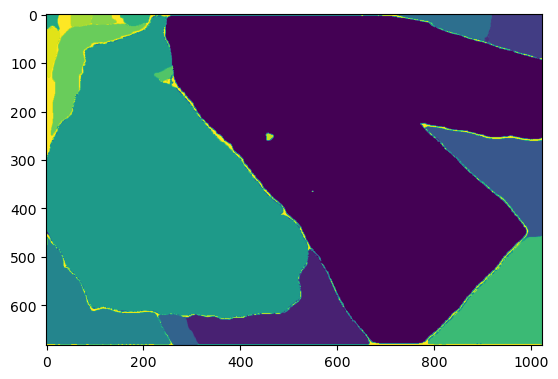

In [59]:
# print(class_img_out)
plt.imshow(class_img_out)


In [60]:
# Convert new masks

result_masks = []

index = 0

for a in new_masks:
    b = {
        "segmentation": a,
        "area": np.count_nonzero(a)
    }

    m = rgba_image.copy()
    m[a == False] = [0, 0, 0, 0]
    PIL_image = Image.fromarray(m)
    PIL_image.save("output/"+str(index)+"_mask.png")
    index += 1

    result_masks.append(b)


In [61]:
print(len(result_masks))
print(len(masks))


22
23


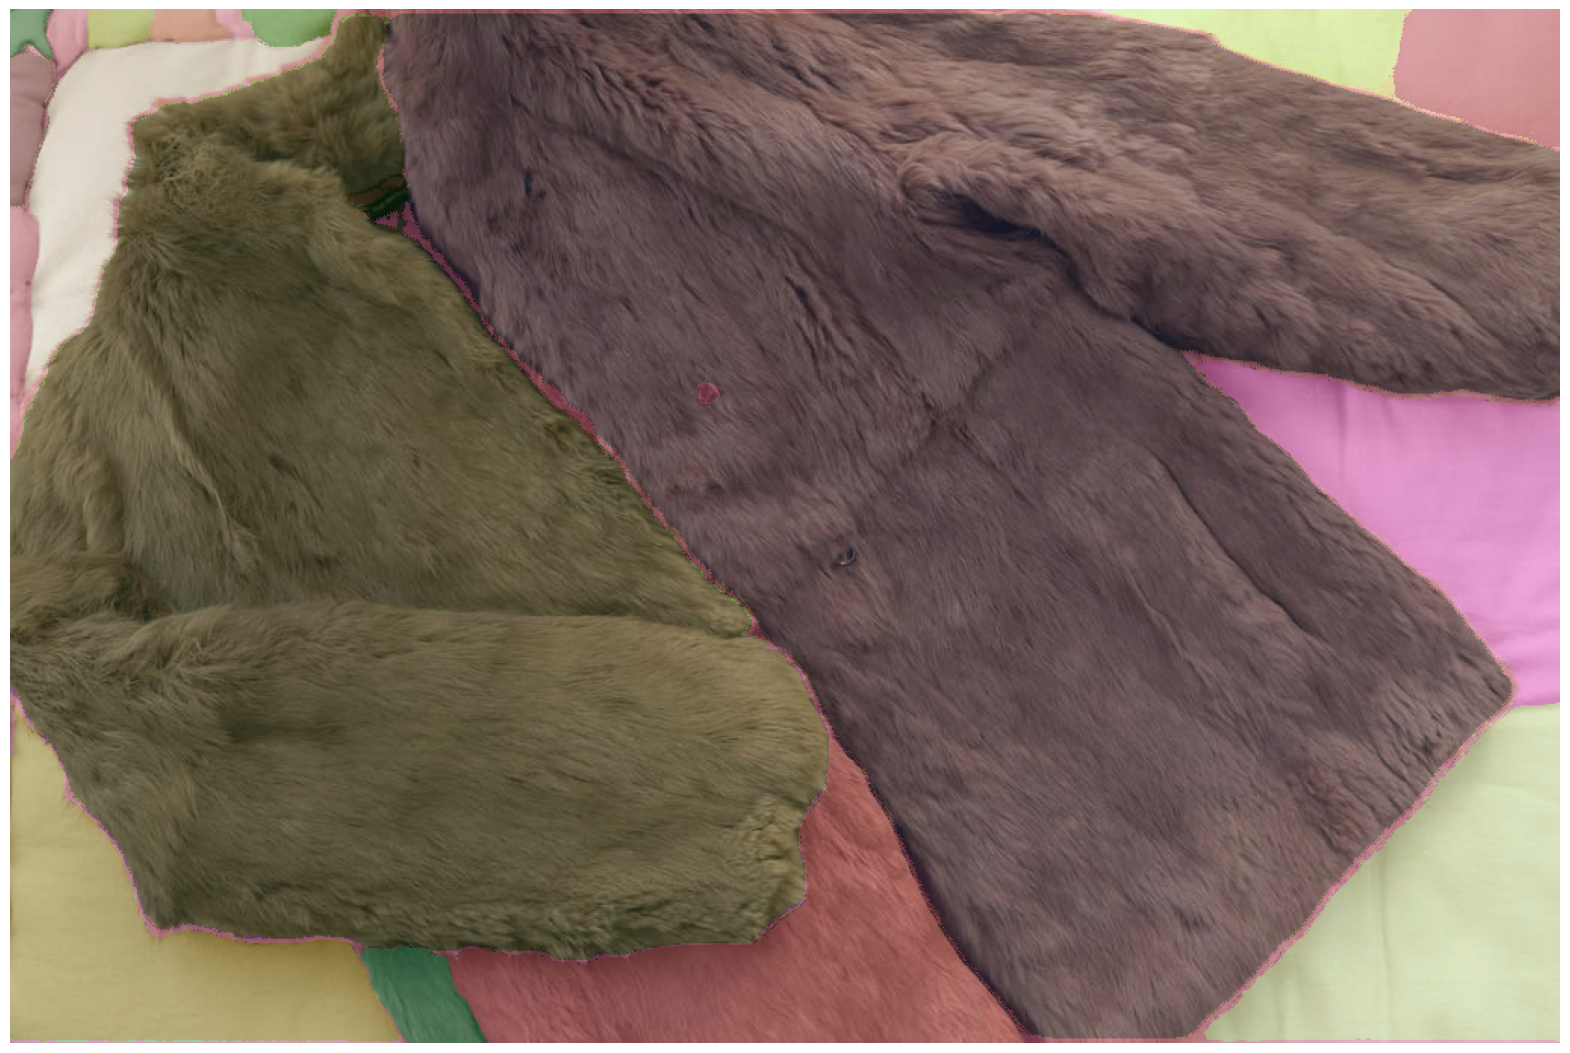

In [62]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(result_masks)
plt.axis('off')
plt.show()


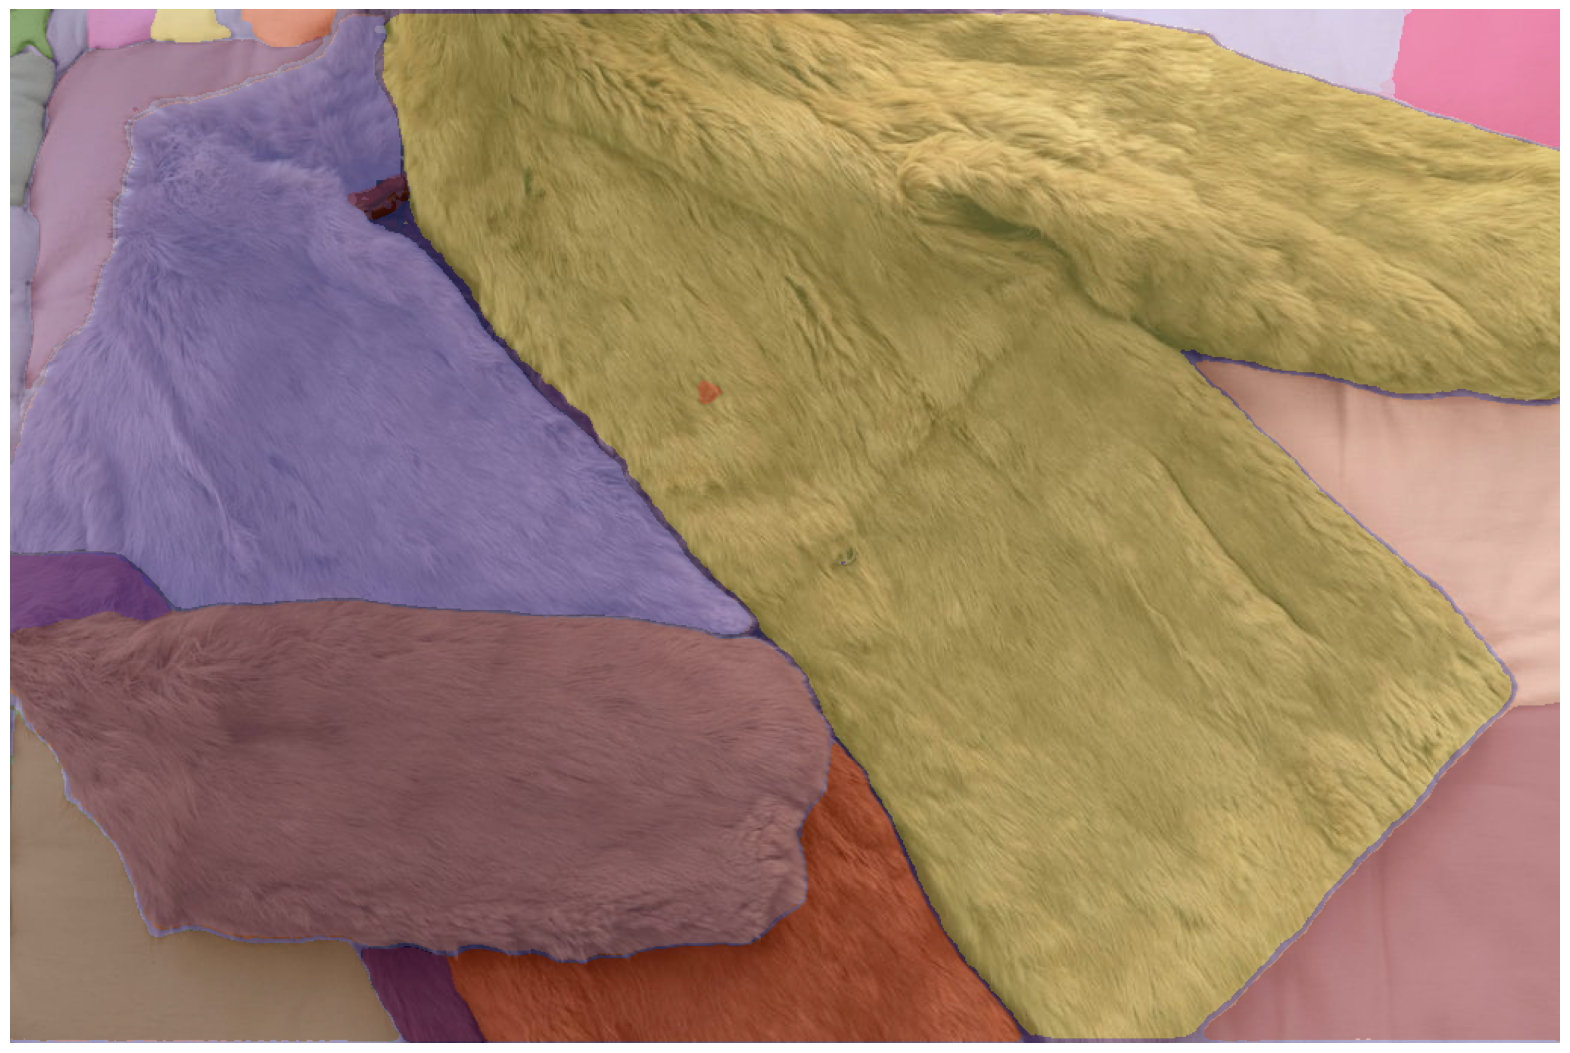

In [63]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()


In [64]:
# Convert new masks
index = 0

for a in masks:
    m = rgba_image.copy()
    x = a["segmentation"]
    m[x == False] = [0, 0, 0, 0]
    PIL_image = Image.fromarray(m)
    PIL_image.save("output/parts/"+str(index)+"_mask.png")
    index += 1


FileNotFoundError: [Errno 2] No such file or directory: 'output/parts/0_mask.png'